In [2]:
import torch
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from torchvision import transforms

train_transform = transforms.Compose(
     [transforms.RandomHorizontalFlip(),
      transforms.RandomCrop(32),
      transforms.RandomRotation(30),
      transforms.ToTensor(),
      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
test_transform = transforms.Compose(
       [transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

traindata = CIFAR100(root='./data', train=True, download=True, transform=train_transform)
testdata = CIFAR100(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class basicblock(nn.Module):
    def __init__(self,inchannel,outchannel,stride=1):
        super(basicblock,self).__init__()
        self.conv1 = nn.Conv2d(inchannel,outchannel,kernel_size=3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(outchannel)
        self.conv2 = nn.Conv2d(outchannel,outchannel,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(outchannel)
        
        self.shortcut=nn.Sequential()
        if stride !=1 or inchannel!=outchannel:
            self.shortcut=nn.Sequential(
                nn.Conv2d(inchannel,outchannel,kernel_size=1,stride=stride),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=F.relu(self.bn2(self.conv2(out)))
        out+=self.shortcut(x)
        out=F.relu(out)
        return out

In [0]:
class ResNet(nn.Module):
    def __init__(self,block,block_list):
        super(ResNet, self).__init__()
        self.inchannel=32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv_drop = nn.Dropout(p=0.5)
        self.conv2 = self._make_layer(block, 32, block_list[0], stride=1)
        self.conv3 = self._make_layer(block, 64, block_list[1], stride=2)
        self.conv4 = self._make_layer(block, 128, block_list[2], stride=2)
        self.conv5 = self._make_layer(block, 256, block_list[3], stride=2)
        self.pool = nn.MaxPool2d(4)
        self.linear = nn.Linear(256, 100)
        
    def _make_layer(self, block, outchannel, num_blocks, stride):
        strides=[stride]+[1]*(num_blocks-1)
        layer=[]
        for stride in strides:
            layer.append(block(self.inchannel,outchannel,stride=stride))
            self.inchannel=outchannel
            return nn.Sequential(*layer)
                         
    def forward(self,x):
        out=F.relu(self.bn1(self.conv1(x)))
        out=self.conv2(out)
        out=self.conv3(out) 
        out=self.conv4(out)
        out=self.conv5(out)
        out=self.pool(out)
        out=out.view(out.size(0),-1)
        out=self.linear(out)
        return out

In [0]:
class Model_Trainer():
    def __init__(self,model,criterion,optimizer,batchSize,trainset,testset,scheduler):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                            shuffle=True, num_workers=2)
        self.testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                            shuffle=False, num_workers=2)
        self.epoch_num_trained = 0
        #self.costs = []
        self.costs_step = []
        self.test_accus = []
        self.train_accus =[]
        self.scheduler=scheduler
        
    def train(self,n_epochs):
        for epoch in range(n_epochs):
            self.scheduler.step()
            self.model.train()
            cost = 0
            a = len(self.trainloader)
            for i, data in enumerate(self.trainloader, 0):
                inputs, labels = data
                inputs = Variable(inputs).cuda()
                labels = Variable(labels).cuda()
                
                
                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                cost += loss.item()/a
            self.epoch_num_trained +=1
            if (self.epoch_num_trained)%(2) == 0 or epoch==0: 
                train_a =self.train_accu()
                test_a = self.test_accu()
                print (str(self.epoch_num_trained),cost," str(train_a): ",train_a," str(test_a): ",test_a)
                self.test_accus.append(train_a)
                self.train_accus.append(test_a)
                #self.costs.append(cost)
                self.costs_step.append(self.epoch_num_trained)
        #self.costs.append(cost)
        self.test_accus.append(train_a)
        self.train_accus.append(test_a)
        self.costs_step.append(self.epoch_num_trained)
        return 1
    
    def test_accu(self):
        
        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                images = Variable(images).cuda()
                labels = Variable(labels).cuda()
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()           
               
        return 100.0*correct/total
    
    
    def train_accu(self):
        correct = 0
        total = 0
        self.model.eval()
        with torch.no_grad():
            for data in self.trainloader:
                images, labels = data
                images = torch.autograd.Variable(images).cuda()
                labels = torch.autograd.Variable(labels).cuda()
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        return 100.0*correct/total
        

In [0]:
from torch.autograd import Variable
import torch.optim as optim
mynet = ResNet(basicblock, [2,4,4,2]).cuda()
criterion = nn.CrossEntropyLoss()
alpha = 0.001
optimizer = optim.Adam(mynet.parameters(),lr = alpha)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,30,40], gamma=0.2)
batch_size=128
mynet_trainer = Model_Trainer(mynet,criterion,optimizer,batch_size,traindata,testdata,scheduler)

In [10]:
mynet_trainer.train(40)

1 3.6826834574989635  str(train_a):  20.572  str(test_a):  21.26
2 2.9556277840948484  str(train_a):  31.356  str(test_a):  31.4
4 2.318838505488834  str(train_a):  42.194  str(test_a):  41.77
6 1.9497095267181197  str(train_a):  50.568  str(test_a):  47.33
8 1.6895516022391934  str(train_a):  55.93  str(test_a):  50.59
10 1.4859422265416222  str(train_a):  60.126  str(test_a):  53.09
12 1.3273919011320907  str(train_a):  65.2  str(test_a):  55.04
14 1.1949757028113839  str(train_a):  68.704  str(test_a):  56.38
16 1.0837883981292509  str(train_a):  71.376  str(test_a):  56.75
18 0.9814791185471706  str(train_a):  73.066  str(test_a):  57.11
20 0.8941702423498151  str(train_a):  75.906  str(test_a):  57.65
22 0.6390767377203379  str(train_a):  83.928  str(test_a):  60.56
24 0.5825726113965746  str(train_a):  85.496  str(test_a):  60.15
26 0.5438141453906398  str(train_a):  86.372  str(test_a):  60.55
28 0.5159632728227873  str(train_a):  87.298  str(test_a):  61.0
30 0.4834601392069132

1

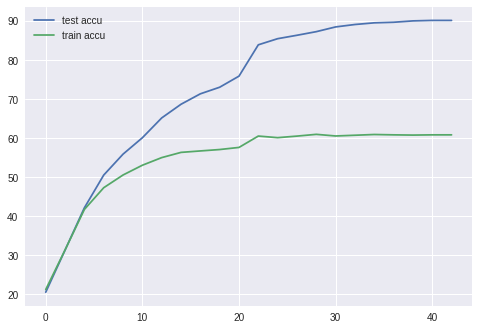

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

plt.plot(np.arange(len(mynet_trainer.test_accus))*2.,mynet_trainer.test_accus,label="test accu")
plt.plot(np.arange(len(mynet_trainer.test_accus))*2.,mynet_trainer.train_accus,label="train accu")
plt.legend(loc="best")
#plt.show()
plt.savefig("yuan_config.png")
files.download("yuan_config.png")
plt.show()

In [12]:
mynet_trainer.train_accu()

90.334

In [13]:
mynet_trainer.test_accu()

60.87